<a href="https://colab.research.google.com/github/akitim/SkillFactory_projects/blob/main/Project_2_EDA_Timofey_Akimkin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Подготовка среды

In [ ]:
import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
from itertools import combinations
from scipy.stats import ttest_ind
 
%matplotlib inline
 
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок
 
import sys
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
sys.path.clear
sys.path.append('/content/gdrive/MyDrive/SkillFactory')

Mounted at /content/gdrive


#Считывание датафрейма из файла

In [ ]:
students = pd.read_csv('/content/gdrive/MyDrive/SkillFactory/stud_math.csv')
display(students.sample(10))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
158,GP,M,16,R,GT3,NaN,2.0,2.0,at_home,other,course,mother,3.0,1.0,NaN,no,no,no,no,no,-3.0,NaN,no,no,4.0,2.0,2.0,3.0,2.0,75.0
246,GP,M,17,U,GT3,T,2.0,3.0,other,other,course,father,2.0,1.0,0.0,no,NaN,NaN,no,yes,-3.0,yes,yes,no,5.0,2.0,2.0,2.0,4.0,65.0
179,GP,M,17,U,GT3,T,4.0,3.0,other,other,course,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,5.0,2.0,3.0,2.0,4.0,55.0
70,GP,M,16,U,GT3,T,3.0,1.0,other,other,reputation,father,NaN,4.0,0.0,no,yes,yes,no,yes,-12.0,yes,yes,no,4.0,3.0,2.0,5.0,0.0,75.0
364,MS,F,17,R,GT3,NaN,1.0,2.0,other,services,course,NaN,2.0,2.0,0.0,no,no,no,no,no,-6.0,yes,no,no,3.0,2.0,2.0,3.0,0.0,60.0
142,GP,F,15,U,GT3,T,4.0,NaN,teacher,services,course,mother,NaN,3.0,0.0,no,yes,yes,yes,yes,-9.0,NaN,yes,no,4.0,2.0,2.0,5.0,2.0,55.0
335,GP,F,17,U,GT3,T,3.0,4.0,services,other,NaN,mother,1.0,3.0,0.0,no,NaN,no,no,yes,-9.0,yes,yes,no,4.0,4.0,5.0,5.0,16.0,75.0
196,GP,M,17,U,GT3,T,4.0,4.0,services,teacher,NaN,mother,1.0,1.0,0.0,no,no,no,no,yes,-3.0,yes,yes,no,5.0,2.0,3.0,5.0,4.0,80.0
288,GP,M,18,U,GT3,T,2.0,1.0,services,services,reputation,mother,1.0,3.0,0.0,no,no,yes,yes,yes,-9.0,yes,yes,no,4.0,2.0,4.0,2.0,6.0,70.0
49,GP,F,15,U,GT3,T,4.0,4.0,services,teacher,other,NaN,1.0,2.0,1.0,yes,yes,no,yes,no,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,2.0,35.0


#Пользовательские функции

In [ ]:
# функция принимает датафрейм, выводит value_counts по всем столбцам
# и количество значений NaN в каждом столбце
def counts_info(df):
    for col in df.columns:
        vc = df.loc[:, col].value_counts(dropna=False)
        display(pd.DataFrame(vc))
        if vc[pd.isna(vc.index)].empty:
            msg = f'\nВ столбце {col} не содержится значений NaN\n'
        else:
            nnan = vc[pd.isna(vc.index)].values[0]
            msg = f'\nВ столбце {col} содержится значений NaN: {nnan}\n'    
        print (f'\nВ столбце {col} значений, встречающихся больше 10 раз: '
            , (df.loc[:, col].value_counts() > 10).sum())
        print (msg)
        print ('---------------------------------------------------')

#функция принимает столбец датафрейма students
#и строит график типа boxplot для распределения
#столбца score по категориальным столбцам
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(
        x=column,
        y='score',
        data=students.loc[students.loc[:, column].isin(students.loc[:, column].
                    value_counts().index[:10])],
        ax=ax
    )
    plt.xticks(rotation=45)
    ax.set_title('Boxplot для ' + column)
    ax.set_ylim(bottom=0,top=110)
    plt.show()
 
# Функция принимает столбец датафрейма в виде <pandas.Series>
# и строит полную гистограмму данных серии и гистограмму
# внутри границ выбросов, если аргумент plot_hist=True.
# Возвращает список: [нижняя гр. выбросов, верхняя гр. выбросов, IQR]
def find_IQR_outliers(se, plot_hist=True):
    quant25 = se.quantile(0.25)
    quant75 = se.quantile(0.75)
    IQR = quant75 - quant25
    lower_bound = quant25 - 1.5*IQR
    upper_bound = quant75 + 1.5*IQR
    
    if plot_hist:
        print (f'Гистограмма для {se.name}')
        print (
            f'Межквартильный интервал: [ {quant25}, {quant75} ]'
        )
        print (
            f'Границы выбросов: [ {lower_bound}, {upper_bound} ]'
        )
        se.loc[se.between(lower_bound, upper_bound)].hist(
            bins = 16,
            range = (se.min(), se.max()),
            label = 'IQR'
        )
        se.hist(
            alpha = 0.5,
            bins = 16,
            range = (se.min(), se.max()),
            label = 'All'
        )
        plt.legend()
        plt.show()
 
    return [lower_bound, upper_bound, IQR]
 
# Функция принимает колонку с номинативными данными датафрейма
# в виде <pandas.Series> и проводит двухсторонний тест Стьюдента
# по выборкам переменной score, соотв. всевозможным парам значений
# номинативных признаков
def get_stat_dif(column, alpha=0.05, most_freq=5):
    # взяты 5 наиболее часто встречающихся значений, можно варьировать
    cols = students.loc[:, column].value_counts(dropna=True).index[:most_freq] 
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(
              students.loc[students.loc[:, column] == comb[0], 'score'], 
              students.loc[students.loc[:, column] == comb[1], 'score']
            ).pvalue <= alpha/len(combinations_all): # поправка Бонферрони
            print('Найдены статистически значимые различия для столбца', column)
            break

#Анализ значений столбцов

In [ ]:
#Приведем названия столбцов к однообразному виду
students.columns = map(lambda s: s.replace(', ', '_').lower(),
                            students.columns)
print(students.columns)

Index(['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'medu', 'fedu',
       'mjob', 'fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime_granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')


#Числовые столбцы

In [ ]:
# проверим, какие значения присутствуют в числовых столбцах
# и сколько из них значений NaN
full_row_index = 4 #в строке 4 все значения корректные
counts_info(students.loc[:, students.loc[full_row_index, :].apply(type) != str])

,age
16,104
17,98
18,82
15,82
19,24
20,3
22,1
21,1



В столбце age значений, встречающихся больше 10 раз:  5

В столбце age не содержится значений NaN

---------------------------------------------------


,medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3
NaN,3



В столбце medu значений, встречающихся больше 10 раз:  4

В столбце medu содержится значений NaN: 3

---------------------------------------------------


,fedu
2.0,106
3.0,96
4.0,88
1.0,78
NaN,24
0.0,2
40.0,1



В столбце fedu значений, встречающихся больше 10 раз:  4

В столбце fedu содержится значений NaN: 24

---------------------------------------------------


,traveltime
1.0,242
2.0,96
NaN,28
3.0,22
4.0,7



В столбце traveltime значений, встречающихся больше 10 раз:  3

В столбце traveltime содержится значений NaN: 28

---------------------------------------------------


,studytime
2.0,194
1.0,103
3.0,64
4.0,27
NaN,7



В столбце studytime значений, встречающихся больше 10 раз:  4

В столбце studytime содержится значений NaN: 7

---------------------------------------------------


,failures
0.0,293
1.0,49
NaN,22
2.0,16
3.0,15



В столбце failures значений, встречающихся больше 10 раз:  4

В столбце failures содержится значений NaN: 22

---------------------------------------------------


,studytime_granular
-6.0,194
-3.0,103
-9.0,64
-12.0,27
NaN,7



В столбце studytime_granular значений, встречающихся больше 10 раз:  4

В столбце studytime_granular содержится значений NaN: 7

---------------------------------------------------


,famrel
4.0,182
5.0,99
3.0,62
NaN,27
2.0,17
1.0,7
-1.0,1



В столбце famrel значений, встречающихся больше 10 раз:  4

В столбце famrel содержится значений NaN: 27

---------------------------------------------------


,freetime
3.0,153
4.0,112
2.0,63
5.0,38
1.0,18
NaN,11



В столбце freetime значений, встречающихся больше 10 раз:  5

В столбце freetime содержится значений NaN: 11

---------------------------------------------------


,goout
3.0,127
2.0,101
4.0,84
5.0,52
1.0,23
NaN,8



В столбце goout значений, встречающихся больше 10 раз:  5

В столбце goout содержится значений NaN: 8

---------------------------------------------------


,health
5.0,138
3.0,89
4.0,63
1.0,47
2.0,43
NaN,15



В столбце health значений, встречающихся больше 10 раз:  5

В столбце health содержится значений NaN: 15

---------------------------------------------------


,absences
0.0,111
2.0,60
4.0,53
6.0,31
8.0,21
10.0,17
12.0,12
NaN,12
14.0,12
3.0,8



В столбце absences значений, встречающихся больше 10 раз:  8

В столбце absences содержится значений NaN: 12

---------------------------------------------------


,score
50.0,54
55.0,46
0.0,37
75.0,33
65.0,31
40.0,31
60.0,31
45.0,27
70.0,27
80.0,16



В столбце score значений, встречающихся больше 10 раз:  12

В столбце score содержится значений NaN: 6

---------------------------------------------------


In [ ]:
#  В столбце fedu одно значение >4 (40), вполне вероятно,
#  что это значение неправильно обработанное значение 4.
#  Заменим это значение на 4:
students.loc[students.loc[:, 'fedu'] == 40, 'fedu'] = 4
 
#  В столбце famrel одно значение <0 (-1), вполне вероятно,
#  что это значение неправильно обработанное значение 1
#  Заменим это значение на 1:
students.loc[students.loc[:, 'famrel'] == -1, 'famrel'] = 1
 
# Удалим также из датафрейма строки с пустыми значениями
# столбца score
students.drop(
    students.loc[pd.isna(students.loc[:, 'score']), 'score'].index,
    axis=0,
    inplace=True    
)
 
students.drop(
    students.loc[students.loc[:, 'score'] == 0, 'score'].index,
    axis=0,
    inplace=True    
)

#Строковые столбцы

In [ ]:
# проверим, какие значения присутствуют в строковых столбцах
# и сколько из них значений NaN 
counts_info(students.loc[:, students.loc[full_row_index, :].apply(type) == str])

,school
GP,344
MS,45



В столбце school значений, встречающихся больше 10 раз:  2

В столбце school не содержится значений NaN

---------------------------------------------------


,sex
F,204
M,185



В столбце sex значений, встречающихся больше 10 раз:  2

В столбце sex не содержится значений NaN

---------------------------------------------------


,address
U,291
R,83
NaN,15



В столбце address значений, встречающихся больше 10 раз:  2

В столбце address содержится значений NaN: 15

---------------------------------------------------


,famsize
GT3,255
LE3,107
NaN,27



В столбце famsize значений, встречающихся больше 10 раз:  2

В столбце famsize содержится значений NaN: 27

---------------------------------------------------


,pstatus
T,308
NaN,45
A,36



В столбце pstatus значений, встречающихся больше 10 раз:  2

В столбце pstatus содержится значений NaN: 45

---------------------------------------------------


,mjob
other,127
services,98
at_home,58
teacher,55
health,32
NaN,19



В столбце mjob значений, встречающихся больше 10 раз:  5

В столбце mjob содержится значений NaN: 19

---------------------------------------------------


,fjob
other,194
services,99
NaN,36
teacher,29
at_home,16
health,15



В столбце fjob значений, встречающихся больше 10 раз:  5

В столбце fjob содержится значений NaN: 36

---------------------------------------------------


,reason
course,135
reputation,102
home,101
other,34
NaN,17



В столбце reason значений, встречающихся больше 10 раз:  4

В столбце reason содержится значений NaN: 17

---------------------------------------------------


,guardian
mother,248
father,86
NaN,31
other,24



В столбце guardian значений, встречающихся больше 10 раз:  3

В столбце guardian содержится значений NaN: 31

---------------------------------------------------


,schoolsup
no,331
yes,49
NaN,9



В столбце schoolsup значений, встречающихся больше 10 раз:  2

В столбце schoolsup содержится значений NaN: 9

---------------------------------------------------


,famsup
yes,216
no,135
NaN,38



В столбце famsup значений, встречающихся больше 10 раз:  2

В столбце famsup содержится значений NaN: 38

---------------------------------------------------


,paid
no,197
yes,153
NaN,39



В столбце paid значений, встречающихся больше 10 раз:  2

В столбце paid содержится значений NaN: 39

---------------------------------------------------


,activities
yes,192
no,183
NaN,14



В столбце activities значений, встречающихся больше 10 раз:  2

В столбце activities содержится значений NaN: 14

---------------------------------------------------


,nursery
yes,297
no,77
NaN,15



В столбце nursery значений, встречающихся больше 10 раз:  2

В столбце nursery содержится значений NaN: 15

---------------------------------------------------


,higher
yes,350
NaN,20
no,19



В столбце higher значений, встречающихся больше 10 раз:  2

В столбце higher содержится значений NaN: 20

---------------------------------------------------


,internet
yes,300
no,55
NaN,34



В столбце internet значений, встречающихся больше 10 раз:  2

В столбце internet содержится значений NaN: 34

---------------------------------------------------


,romantic
no,235
yes,123
NaN,31



В столбце romantic значений, встречающихся больше 10 раз:  2

В столбце romantic содержится значений NaN: 31

---------------------------------------------------


В строковых столбцах отсутствуют некорректные значения;
доля пустых значений (NaN) составляет не более ≈10%

In [ ]:
print('\nОбщая характеристика датасета:')
students.info();

print('\nСтатистическая характеристика датасета:')
students.describe()


Общая характеристика датасета:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              389 non-null    object 
 1   sex                 389 non-null    object 
 2   age                 389 non-null    int64  
 3   address             374 non-null    object 
 4   famsize             362 non-null    object 
 5   pstatus             344 non-null    object 
 6   medu                386 non-null    float64
 7   fedu                365 non-null    float64
 8   mjob                370 non-null    object 
 9   fjob                353 non-null    object 
 10  reason              372 non-null    object 
 11  guardian            358 non-null    object 
 12  traveltime          361 non-null    float64
 13  studytime           382 non-null    float64
 14  failures            367 non-null    float64
 15  schoolsup           380 n

,age,medu,fedu,traveltime,studytime,failures,studytime_granular,famrel,freetime,goout,health,absences,score
count,389.000000,386.000000,365.000000,361.000000,382.000000,367.000000,382.000000,362.000000,380.000000,382.000000,374.000000,378.000000,389.000000
mean,16.673522,2.766839,2.528767,1.434903,2.036649,0.326975,-6.109948,3.936464,3.223684,3.094241,3.529412,7.320106,52.262211
std,1.265662,1.094277,1.088082,0.692660,0.847239,0.729479,2.541716,0.907858,0.993364,1.116104,1.402006,23.615525,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


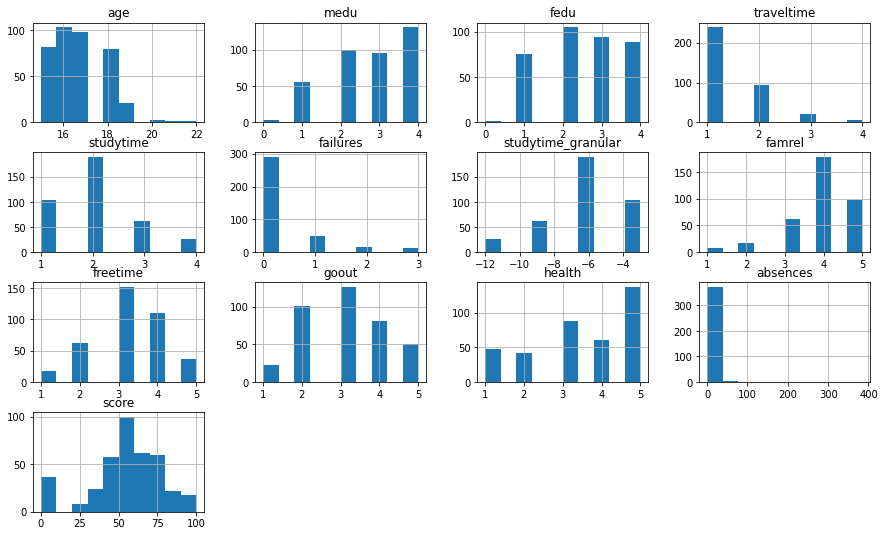

In [ ]:
students.hist(figsize =(15,9));

Гистограмма для absences
Межквартильный интервал: [ 0.0, 8.0 ]
Границы выбросов: [ -12.0, 20.0 ]


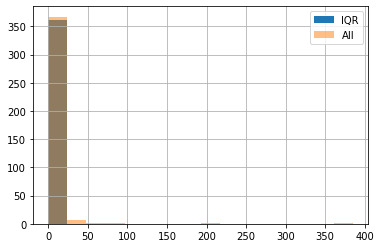

Гистограмма для score
Межквартильный интервал: [ 40.0, 70.0 ]
Границы выбросов: [ -5.0, 115.0 ]


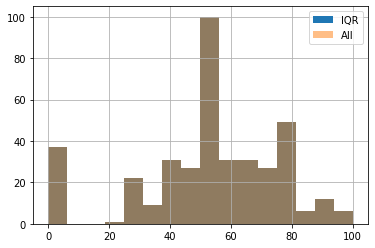

In [ ]:
for col in ['absences', 'score']:
    find_IQR_outliers(students.loc[:, col])

In [ ]:
#Значения score, равные нулю 

students.drop(
    students.loc[students.loc[:, 'score'] == 0, 'score'].index,
    axis=0,
    inplace=True    
)

In [ ]:
# Посмотрим, сколько значений absences лежат
# вне границ выбросов:

mask_absences_in = students.loc[:, 'absences'].between(
    find_IQR_outliers(students.loc[:, 'absences'], False)[0],
    find_IQR_outliers(students.loc[:, 'absences'], False)[1]
)
num_of_out_abscences = students.loc[mask_absences_in.apply(lambda x: not(x)), 
             'absences'].count()
print(
    'Вне границ выбросов лежат:', num_of_out_abscences,
    '(≈', round(num_of_out_abscences / students.loc[:, 'absences'].count()*100),
    '%) значений столбца absences'
)

Вне границ выбросов лежат: 17 (≈ 4 %) значений столбца absences


In [ ]:
# Это небольшая доля значений, можно считать их выбросами
# и удалить из столбца absences:
students.loc[
             mask_absences_in.apply(lambda x: not(x)), 'absences'
] = None
#pd.DataFrame(students.loc[:, 'absences']).info()

#Корреляционный анализ

In [ ]:
#sns.pairplot(students, kind = 'reg');
# plt.figure(figsize=(10,8), dpi= 80)
# sns.pairplot(students, kind="scatter", hue="sex", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
# plt.legend()
# plt.show();

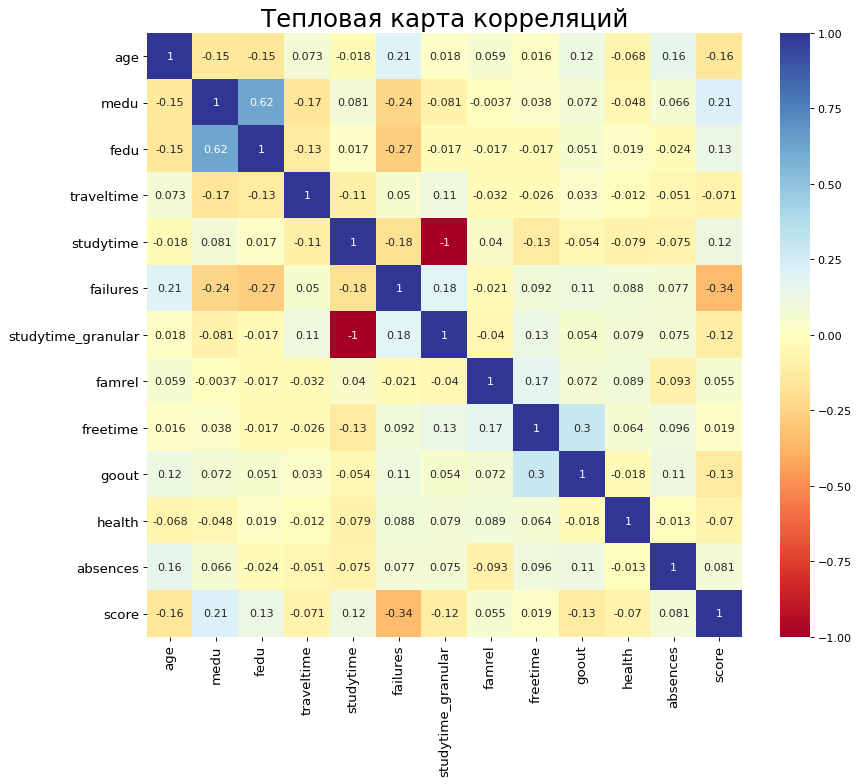

In [ ]:
# Построим тепловую карту корреляций числовых данных
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(
    students.corr(),
    xticklabels=students.corr().columns,
    yticklabels=students.corr().columns,
    cmap= 'RdYlBu', #'RdYlGn',
    center=0,
    annot=True
)

plt.title('Тепловая карта корреляций', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# Столбец studytime_granular полностью антикореллирован со столбцом
# studytime и может быть исключен:
students.drop(['studytime_granular'], inplace = True, axis = 1)

# Также довольно сильно скореллированы (коэф. корр. ~0,63) столбцы
# fedu и medu, одну из переменных можно убрать из рассмотрения,
# Пусть это будет medu:
students.drop(['medu'], inplace = True, axis = 1)

#Анализ номинативных переменных

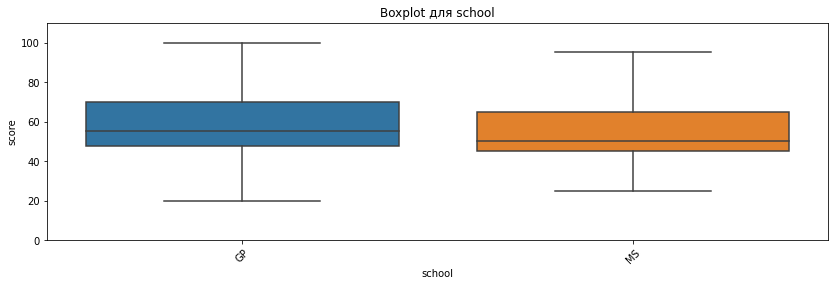

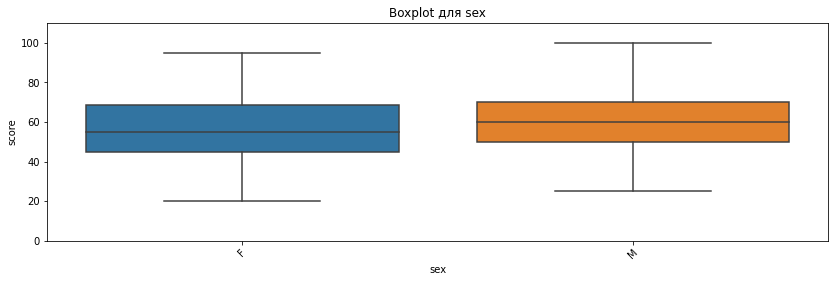

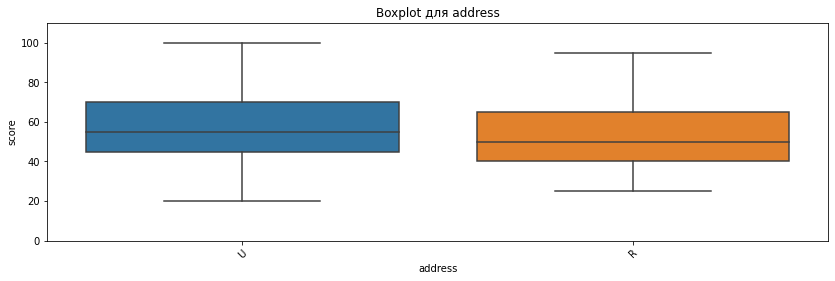

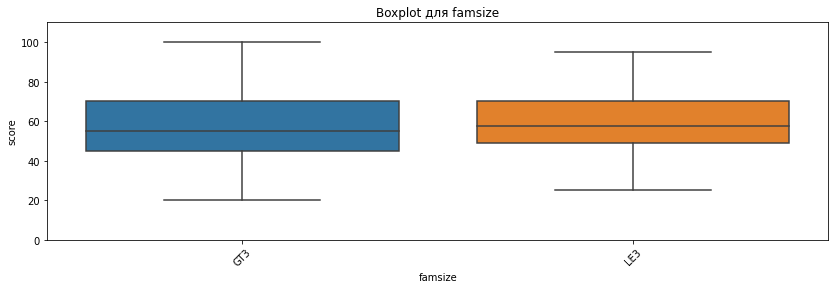

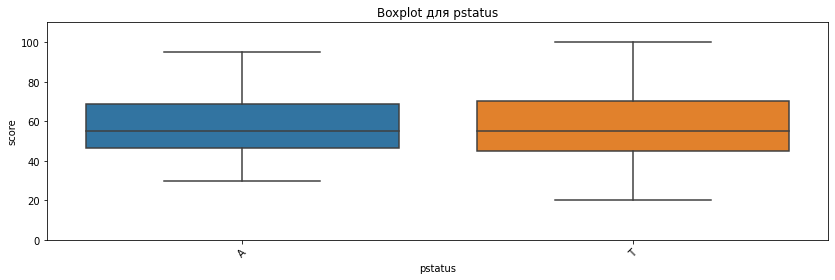

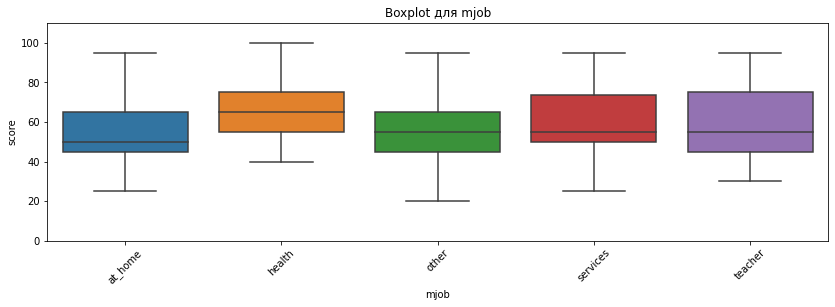

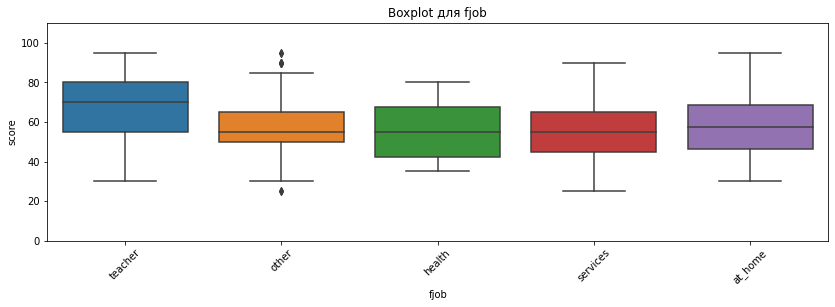

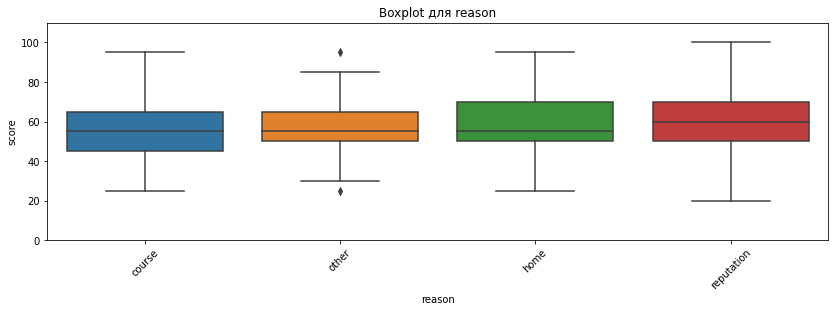

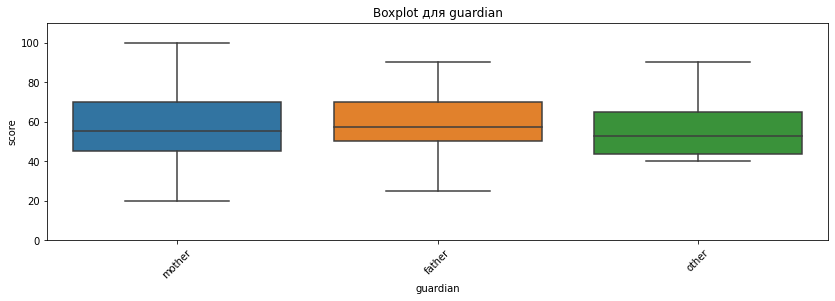

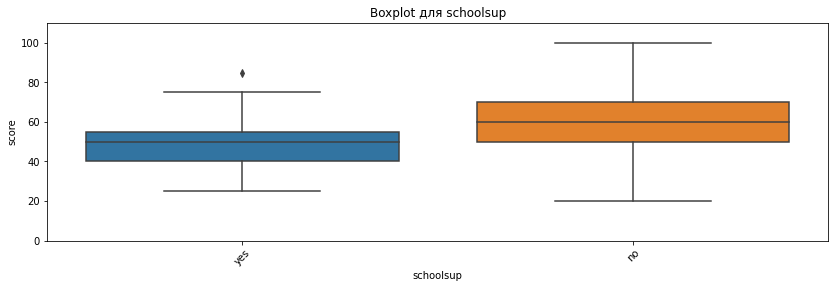

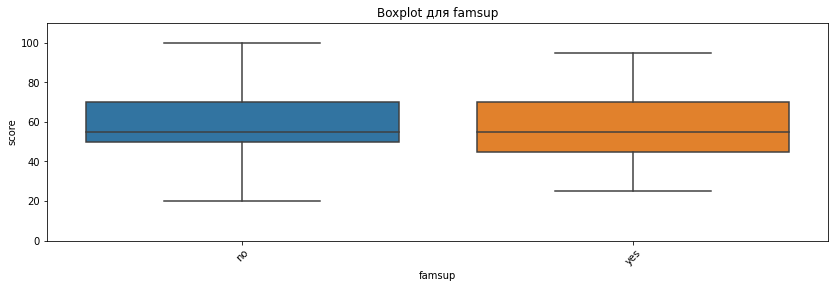

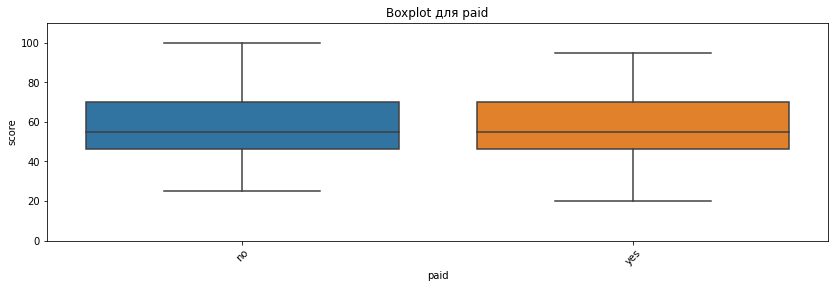

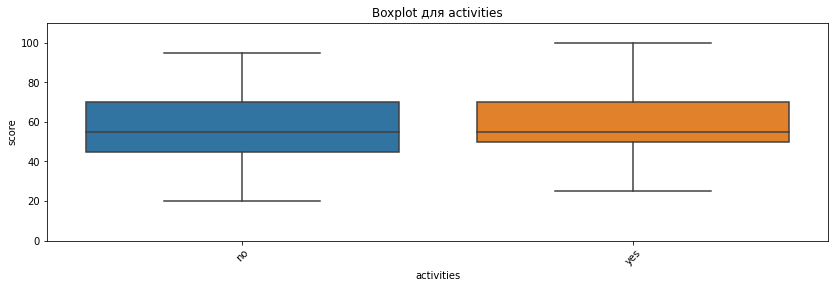

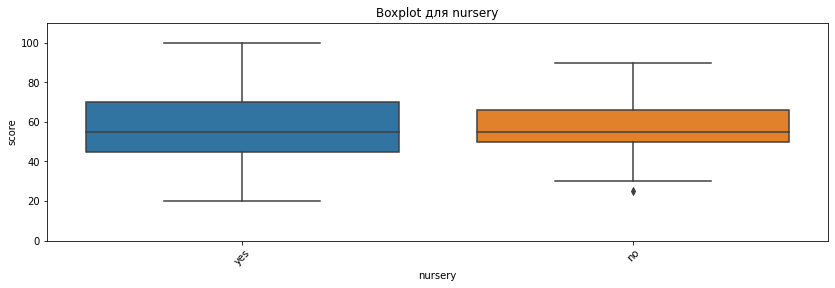

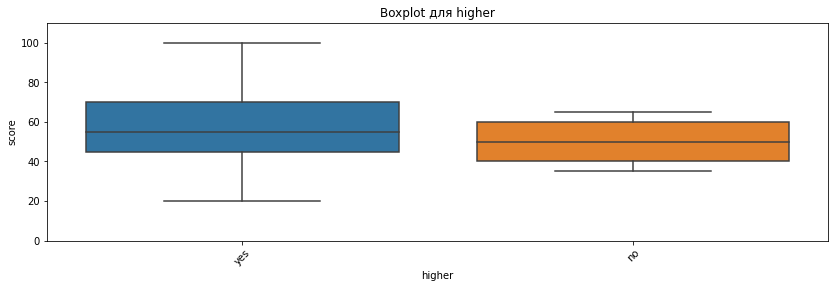

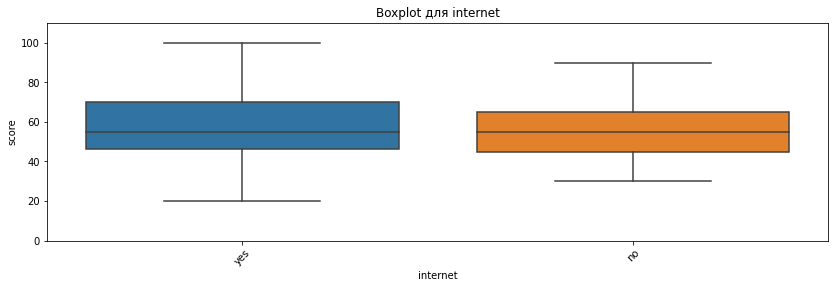

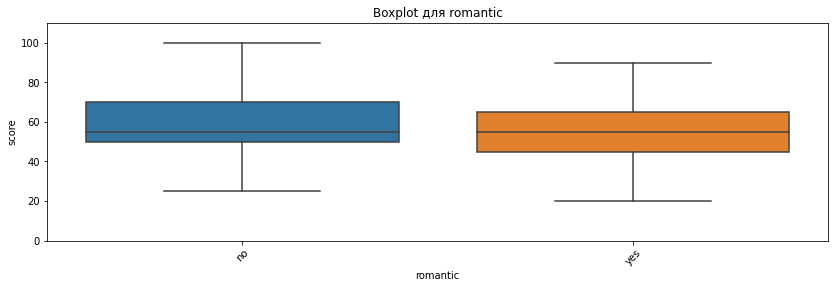

In [ ]:
#список столбцов с номинативными данными
nom_data_cols = \
    students.loc[:, students.loc[full_row_index, :].apply(type) == str].columns

# Построим графики boxplot для номинативных переменных и 
# оценим по ним, какие переменные могут влиять на переменную score
for col in nom_data_cols:
    get_boxplot(col)

In [ ]:
# Исходя из графиков, на переменную score могут влиять столбцы
# address, pstatus, mjob, fjob, reason,
# guardian, schoolsup, higher, internet 

# Оценим статистическую значимость различия средних значений параметра score,
# распределенного по различным номинативным характеристикам с помощью
# двухстороннего теста Стьюдента с учетом поправки Бонферрони:

for col in nom_data_cols:
    get_stat_dif(col, 0.05, 5)

Найдены статистически значимые различия для столбца address
Найдены статистически значимые различия для столбца mjob
Найдены статистически значимые различия для столбца fjob
Найдены статистически значимые различия для столбца schoolsup


In [ ]:
# Подготовим окончательный вариант датафрейма для построения модели,
# оставив только числовые переменные и номинативные переменные, для 
# которых были найдены статистически значимые отличия в средних значениях
# целевой переменной score

#фильтруем числовые столбцы
num_data_cols = \
    students.loc[:, students.loc[full_row_index, :].apply(type) != str].columns
    
students_for_model = students.loc[:,[
                                     'address',
                                     'mjob',
                                     'higher',
                                     'romantic'
                                    ] + list(num_data_cols)
]
students_for_model


,address,mjob,higher,romantic,age,fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
0,U,at_home,yes,no,18,4.0,2.0,2.0,0.0,4.0,3.0,4.0,3.0,6.0,30.0
1,U,at_home,yes,no,17,1.0,1.0,2.0,0.0,5.0,3.0,3.0,3.0,4.0,30.0
2,U,at_home,yes,NaN,15,1.0,1.0,2.0,3.0,4.0,3.0,2.0,3.0,10.0,50.0
3,U,health,yes,yes,15,2.0,1.0,3.0,0.0,3.0,2.0,2.0,5.0,2.0,75.0
4,U,other,yes,no,16,3.0,1.0,2.0,0.0,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,U,services,yes,no,20,2.0,1.0,2.0,2.0,5.0,5.0,4.0,4.0,NaN,45.0
391,U,services,yes,no,17,1.0,2.0,1.0,0.0,2.0,4.0,5.0,2.0,3.0,80.0
392,R,other,NaN,no,21,1.0,1.0,1.0,3.0,5.0,5.0,3.0,3.0,3.0,35.0
393,R,services,yes,no,18,2.0,3.0,1.0,0.0,4.0,4.0,1.0,5.0,0.0,50.0


# ***Выводы:***

---




*   В данных присутствуют пустые значения, но их доля не превышает ≈ 10  %.
*   Новый пункт

